In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
df_gscore = pd.read_csv('genome-scores.csv')
df_gtags = pd.read_csv('genome-tags.csv')
df_links = pd.read_csv('links.csv')
df_movies = pd.read_csv('movies.csv')
df_rating = pd.read_csv('ratings.csv')
df_tagspd = pd.read_csv('tags.csv')

## Creating the genome dataset

In [2]:
df_gtagscore=df_gtags.merge(df_gscore, how='right', on='tagId').drop('tag', axis =1)
df_gtagscore.drop_duplicates(subset=['tagId', 'movieId'],inplace=True)
df_gtagscore.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   tagId      11709768 non-null  int64  
 1   movieId    11709768 non-null  int64  
 2   relevance  11709768 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 357.4 MB


# pivoting the datafram

In [3]:
df_gtagscore = df_gtagscore.pivot(index = 'movieId', columns = 'tagId', values='relevance')

In [4]:
df_gtagscore.shape

(10381, 1128)

## adding realease year and genres as columns

In [9]:
df_movies = pd.read_csv('movies.csv')
mask = df_movies['title'].str.contains('09–')

df_movies = pd.read_csv('movies.csv')
def condition(x):
    if x[-2:]=='a)':
        return np.nan
    elif x[-2:]=='l)':
        return np.nan
    elif x[-3:-1]=='7-':
        return 2007
    elif x[-4:-2]=='9–':
        return 2009
    elif x[-2:]=='))':
        return x[-6:-2]
    elif x[-1:]==')':
        return x[-5:-1]
    elif x[-1:]==' ':
        return x[-6:-2]
    else:
        return np.nan
df_movies['releaseyear'] = df_movies['title'].apply(condition).fillna(1993)

In [10]:
df_movies.genres= df_movies.genres.str.split('|')
dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)
df_movies = pd.concat([df_movies, dummies], axis=1).drop('genres', axis=1)

C:\Users\HamidEsfahlani\AppData\Local\Temp\ipykernel_2564\1447042938.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)


In [11]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
df_movies =df_movies.drop('title', axis =1)
"""
le = LabelEncoder()
le.fit(df_movies.genres)
df_movies.genres= le.transform(df_movies.genres)

scaler = MinMaxScaler()
df_movies.genres = scaler.fit_transform(df_movies[['genres']])
"""
scaler02 = MinMaxScaler()
df_movies.releaseyear = scaler02.fit_transform(df_movies[['releaseyear']])

In [12]:
df_ContBaseRec = pd.merge(df_gtagscore, df_movies, how='inner', on='movieId').set_index('movieId')
df_ContBaseRec.columns = df_ContBaseRec.columns.astype(str)

# Clustering

## importing the libraries

In [13]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## training the Model

In [14]:
kmeans = KMeans(n_clusters=18, n_init='auto')
kmeans.fit(df_ContBaseRec)
labels = kmeans.labels_

## seeing and visualizing the distribution

In [16]:
unique_values, counts= np.unique(labels, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} occurrences")

0: 233 occurrences
1: 526 occurrences
2: 537 occurrences
3: 752 occurrences
4: 536 occurrences
5: 718 occurrences
6: 558 occurrences
7: 1148 occurrences
8: 1265 occurrences
9: 404 occurrences
10: 587 occurrences
11: 238 occurrences
12: 464 occurrences
13: 613 occurrences
14: 461 occurrences
15: 554 occurrences
16: 341 occurrences
17: 446 occurrences


''

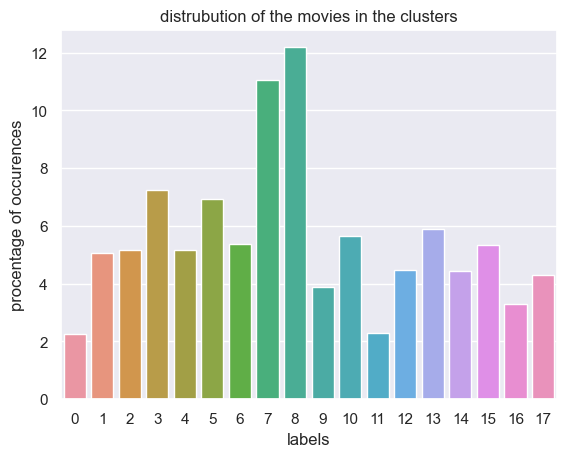

In [17]:
g=sns.barplot(x=unique_values, y=(counts/labels.size)*100)
g.set(xlabel='labels', ylabel='procentage of occurences', title='distrubution of the movies in the clusters')
;

## random sampling

In [80]:
df_movies = pd.read_csv('movies.csv')
df_labeledMovies= pd.DataFrame({'movieId': df_ContBaseRec.index, 'labels': labels}).merge(df_movies, on='movieId').set_index('movieId')
df_labeledMovies[df_labeledMovies.labels==1].head(10)

,labels,title,genres
movieId,,,
30,1,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama
59,1,"Confessional, The (Confessionnal, Le) (1995)",Drama|Mystery
97,1,"Hate (Haine, La) (1995)",Crime|Drama
123,1,Chungking Express (Chung Hing sam lam) (1994),Drama|Mystery|Romance
154,1,Beauty of the Day (Belle de jour) (1967),Drama
199,1,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical|Romance
215,1,Before Sunrise (1995),Drama|Romance
233,1,Exotica (1994),Drama
247,1,Heavenly Creatures (1994),Crime|Drama


In [81]:
df_labeledMovies[df_labeledMovies.labels== 5].head(10)

,labels,title,genres
movieId,,,
70,5,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
152,5,"Addiction, The (1995)",Drama|Horror
177,5,Lord of Illusions (1995),Horror
188,5,"Prophecy, The (1995)",Fantasy|Horror|Mystery
220,5,Castle Freak (1995),Horror
253,5,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
328,5,Tales from the Crypt Presents: Demon Knight (1...,Horror|Thriller
330,5,Tales from the Hood (1995),Action|Crime|Horror
366,5,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


## looking at the movies which are in the same cluster as "Network (1975)"

In [82]:
label =df_labeledMovies[df_labeledMovies.title.str.contains(r'\bNetwork\b.{0,9}$', case=False)].labels.item()
df_labeledMovies[df_labeledMovies.labels== label].head(10)

,labels,title,genres
movieId,,,
6,7,Heat (1995),Action|Crime|Thriller
16,7,Casino (1995),Crime|Drama
47,7,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
50,7,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
111,7,Taxi Driver (1976),Crime|Drama|Thriller
288,7,Natural Born Killers (1994),Action|Crime|Thriller
293,7,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
296,7,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
319,7,Shallow Grave (1994),Comedy|Drama|Thriller
